# Load Data
transforms：把PIL圖片(H,W,C)變成pytorch tensor(C,H,W)，而且會自動標準化至0~1

In [180]:
%%time
import numpy as np
from PIL import Image
from torchvision import transforms
import os
category = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

IMAGE_SIZE = 64
N = 1000
train_X = np.empty((N*10, 3, IMAGE_SIZE,IMAGE_SIZE))
train_Y = np.array([])

for i, c in enumerate(category):
    pic = os.listdir('animal-10/train/'+c)
    pic = pic[:N]
    train_Y = np.concatenate([train_Y, np.asarray([i]*N)],axis=0)
    for j,k in enumerate(pic):
        im = Image.open('animal-10/train/'+c+'/'+k).convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE))
        im = transforms.ToTensor()(im)
        train_X[i*N+j, ...] = im.numpy()

print (train_X.shape)
print (train_Y.shape)

(10000, 3, 64, 64)
(10000,)
Wall time: 18.4 s


In [181]:
N = 400
test_X = np.empty((N*10, 3, IMAGE_SIZE,IMAGE_SIZE))
test_Y = np.array([])

for i, c in enumerate(category):
    pic = os.listdir('animal-10/val/'+c)
    pic = pic[:N]
    test_Y = np.concatenate([test_Y, np.asarray([i]*N)],axis=0)
    for j,k in enumerate(pic):
        im = Image.open('animal-10/val/'+c+'/'+k).convert('RGB').resize((IMAGE_SIZE,IMAGE_SIZE))
        im = transforms.ToTensor()(im)
        test_X[i*N+j, ...] = im.numpy()

print (test_X.shape)
print (test_Y.shape)

(4000, 3, 64, 64)
(4000,)


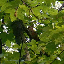

In [182]:
transforms.ToPILImage()(im)

# CNN
注意：pytorch的CNN input shape是(channel, height, width)<br>
nn.Relu跟F.relu的差別：https://www.cnblogs.com/denny402/p/7593301.html<br>
output_shape = (image_shape-filter_shape+2*padding)/stride + 1

In [206]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

FILTER_SIZE_1 = 16
FILTER_SIZE_2 = 32
KERNEL_SIZE_1 = 5
KERNEL_SIZE_2 = 5

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(        
            nn.Conv2d(
                in_channels=train_X.shape[1],  # channel數量
                out_channels=FILTER_SIZE_1,    # filters數量
                kernel_size=KERNEL_SIZE_1,     # filter size
                stride=1,                      # 改stride的數量的話，後面的dense輸入size要記得調
                padding=int((KERNEL_SIZE_1-1)/2),                     # 若想保持圖片的長寬，則padding=(kernel_size-1)/2 if stride=1
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(FILTER_SIZE_1, FILTER_SIZE_2, KERNEL_SIZE_2, 1, int((KERNEL_SIZE_2-1)/2)),     # conv2d(input, output, kernel, stride, padding)
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # Dense & Output
        self.dense = nn.Sequential(
            nn.Linear(FILTER_SIZE_2 * int(IMAGE_SIZE/4) * int(IMAGE_SIZE/4), 32),
            nn.Dropout(DROPOUT),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.Dropout(DROPOUT),
            nn.ReLU(),
            nn.Linear(16, 10),
            # 不用加softmax，不影響訓練，如果想輸出機率再加就好
        )
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # view就是reshape的功能，做成(batch size, -1)
        output = self.dense(x)
        return output

## 要先轉成pytorch的tensor
重點：除了要轉成torch tensor之外，X要轉成float，Y要轉成long!!<br>
train不用放進cuda，batch再放就好，test則要放入cuda

In [194]:
import torch.utils.data as Data
torch_train_X = torch.from_numpy(train_X).type(torch.FloatTensor)
torch_train_Y = torch.from_numpy(np.array(train_Y)).type(torch.LongTensor) 
torch_test_X = torch.from_numpy(test_X).type(torch.FloatTensor)
torch_test_Y = torch.from_numpy(np.array(test_Y)).type(torch.LongTensor)

torch_dataset = Data.TensorDataset(torch_train_X, torch_train_Y)

# Model Training

In [207]:
%%time
EPOCH = 100
LR = 0.001
DROPOUT = 0.1
BATCH_SIZE = 200

cnn = CNN()
cnn.cuda()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   
loss_func = nn.CrossEntropyLoss()

loader = Data.DataLoader(
    dataset=torch_dataset,      
    batch_size=BATCH_SIZE,     
    shuffle=True,   
    num_workers=2,  
)

train_loss, train_acc, test_acc = [], [], []
for epoch in range(1,EPOCH+1):
    for step, (batch_x, batch_y) in enumerate(loader):  
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = cnn(batch_x)               
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # 把這次step的gradient清空
        loss.backward()                 
        optimizer.step()                # apply gradient

        if step % 50 == 0:
            test_acc_class=[]
            # 受限於顯卡記憶體，不能一次把test讀進來，要分class讀
            for i in range(10):
                batch_test_X = torch_test_X[i*400:(i+1)*400,...].cuda()
                batch_test_Y = torch_test_Y[i*400:(i+1)*400,...].cuda()
                
                test_output = cnn(batch_test_X)
                pred_y = torch.max(test_output, 1)[1].cuda().data
                accuracy = torch.sum(pred_y == batch_test_Y).type(torch.FloatTensor) / batch_test_Y.size(0)
                test_acc_class.append(accuracy)
            
            # 計算此次batch的accuracy
            pred_batch_y = torch.max(output, 1)[1].cuda().data
            accuracy_batch = torch.sum(pred_batch_y == batch_y).type(torch.FloatTensor) / batch_y.size(0)
            # 紀錄結果
            train_loss.append(loss.data)
            train_acc.append(accuracy_batch)            
            test_acc.append(np.mean(test_acc_class))

            print('Epoch:', epoch, '| train loss: %.5f' % loss.data,'| train accuracy: %.3f' % accuracy_batch, '| test accuracy: %.3f' % np.mean(test_acc_class))

print ('\nAccuracy of Classes：')
for i,j in zip(category, test_acc_class):
    j = j.numpy()*100
    msg = i+':%.2f' %j+'%'
    print (msg.rjust(20))

Epoch: 1 | train loss: 2.31264 | train accuracy: 0.110 | test accuracy: 0.107
Epoch: 2 | train loss: 2.20938 | train accuracy: 0.185 | test accuracy: 0.182
Epoch: 3 | train loss: 2.01455 | train accuracy: 0.315 | test accuracy: 0.233
Epoch: 4 | train loss: 1.96465 | train accuracy: 0.285 | test accuracy: 0.283
Epoch: 5 | train loss: 1.84054 | train accuracy: 0.350 | test accuracy: 0.318
Epoch: 6 | train loss: 1.80279 | train accuracy: 0.335 | test accuracy: 0.357
Epoch: 7 | train loss: 1.59735 | train accuracy: 0.440 | test accuracy: 0.372
Epoch: 8 | train loss: 1.63193 | train accuracy: 0.475 | test accuracy: 0.381
Epoch: 9 | train loss: 1.62884 | train accuracy: 0.425 | test accuracy: 0.388
Epoch: 10 | train loss: 1.77119 | train accuracy: 0.380 | test accuracy: 0.409
Epoch: 11 | train loss: 1.51709 | train accuracy: 0.430 | test accuracy: 0.426
Epoch: 12 | train loss: 1.48120 | train accuracy: 0.440 | test accuracy: 0.442
Epoch: 13 | train loss: 1.47825 | train accuracy: 0.525 | tes

# Model Evaluation
在evaluate時，記得要先寫cnn.eval()來固定參數，否則預測的結果是會變動的 <br>
pytorch是用train()跟eval()來切換模式 <br>
https://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305d9cd231015d9d0992ef0030

Label： dog 
Predict： cat


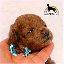

In [208]:
cnn.eval()
o = cnn(torch_test_X[82:83].cuda())
pr = torch.max(o, 1)[1].cuda().data

print ('Label：',category[torch_test_Y[82]],'\nPredict：',category[pr])
transforms.ToPILImage()(torch_test_X[82]).convert('RGB')

Label： cat 
Predict： dog


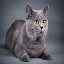

In [209]:
cnn.eval()
N = 2005
o = cnn(torch_test_X[N:N+1].cuda())
pr = torch.max(o, 1)[1].cuda().data

print ('Label：',category[torch_test_Y[N]],'\nPredict：',category[pr])
transforms.ToPILImage()(torch_test_X[N]).convert('RGB')

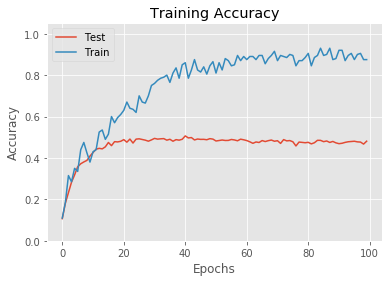

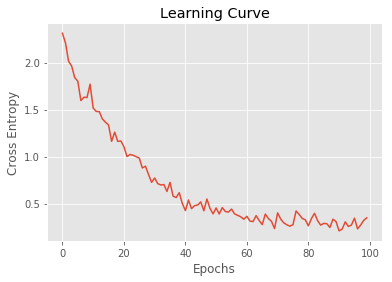

In [210]:
plt.style.use('ggplot')
plt.plot(test_acc, label='Test')
plt.plot(train_acc, label='Train')
plt.legend()
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0,1.05)
plt.show()

plt.plot(train_loss)
plt.title('Learning Curve')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.show()